In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import linearsolve as ls
np.set_printoptions(suppress=True)
%matplotlib inline

# The `linearsolve.model` class

The `linearsolve.model` class package contains a several functions for approximating, solving, and simulating dynamic stochastic general equilibrium (DSGE) models. The equilibrium conditions for most DSGE models can be expressed as a vector function $F$:

\begin{align}
f(E_t X_{t+1}, X_t, \epsilon_{t+1}) = 0,
\end{align}

where 0 is an $n\times 1$ vector of zeros, $X_t$ is an $n\times 1$ vector of endogenous variables, and $\epsilon_{t+1}$ is an $m\times 1$ vector of exogenous structural shocks to the model. $E_tX_{t+1}$ denotes the expecation of the $t+1$ endogenous variables based on the information available to decision makers in the model as of time period $t$. 

The function $f$ is often nonlinear. Because the values of the endogenous variables in period $t$ depend on the expected future values of those variables, it is not in general possible to compute the equilibirum of the model by working directly with the function $f$. Instead it is often convenient to work with a log-linear approximation to the equilibrium conditions around a non-stochastic steady state. In many cases, the log-linear approximation can be written in the following form:

\begin{align}
A E_t\left[ x_{t+1} \right] & = B x_t + \left[ \begin{array}{c} \epsilon_{t+1} \\ 0 \end{array} \right],
\end{align}

where the vector $x_{t}$ denotes the log deviation of the variables in $X_t$ from their steady state values. The variables in $x_t$ are grouped in a specific way: $x_t = [s_t; u_t]$ where $s_t$ is an $n_s \times 1$ vector of predetermined (state) variables and $u_t$ is an $n_u \times 1$ vector of nonpredetermined (forward-looking) variables. $\epsilon_{t+1}$ is an $n_s\times 1$ vector of i.i.d. shocks to the state variables $s_{t+1}$.  $\epsilon_{t+1}$ has mean 0 and diagonal covariance matrix $\Sigma$. The solution to the model is a pair of matrices $F$ and $P$ such that:

\begin{align}
u_t  &  = Fs_t\\
s_{t+1} & = Ps_t + \epsilon_{t+1}.
\end{align}


The matrices $F$ and $P$ are obtained using the [Klein (2000)](http://www.sciencedirect.com/science/article/pii/S0165188999000457) solution method which is based on the generalized Schur factorization of the marices $A$ and $B$. The solution routine incorporates many aspects of his program for Matlab [`solab.m`](http://paulklein.ca/newsite/codes/codes.php).

This package defines a `linearsolve.model` class. An instance of the `linearsolve.model` has the following methods:

1. `compute_ss(guess,method,options)`: Computes the steady state of the nonlinear model.
2. `set_ss(steady_state)`: Sets the steady state `.ss` attribute of the instance.
3. `log_linear_approximation(steady_state,isloglinear)`: Log-linearizes the nonlinear model and constructs the matrices $A$ and $B$.
4. `klein(a,b)`: Solves the linear model using Klein's solution method.
5. `approximate_and_solve(isloglinear)`: Approximates and solves the model by combining the previous two methods.
6. `impulse(T,t0,shock,percent)`: Computes impulse responses for shocks to each endogenous state variable.
7. `approximated(round,precision)`: Returns a string containing the log-linear approximation to the equilibrium conditions of the model.
8. `solved(round,precision)`: Returns a string containing the solution to the log-linear approximation of the model.

In this notebook, I demonstrate how to use the module to simulate two basic business cycle models: an real business cycle (RBC) model and a new-Keynesian business cycle model.

### Example 1:  A quick example.

Here I demonstrate how how relatively straightforward it is to appoximate, solve, and simulate a DSGE model using `linearsolve`. In the example that follows, I describe the procedure more carefully.

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha A_{t+1} K_{t+1}^{\alpha-1} + 1 - \delta)\right]\\
C_t + K_{t+1} & = A_t K_t^{\alpha} + (1-\delta)K_t\\
\log A_{t+1} & = \rho_a \log A_{t} + \epsilon_{t+1}
\end{align}

In the block of code that immediately follows, I input the model, solve for the steady state, compute the log-linear approximation of the equilibirum conditions, and compute some impulse responses following a shock to technology $A_t$.

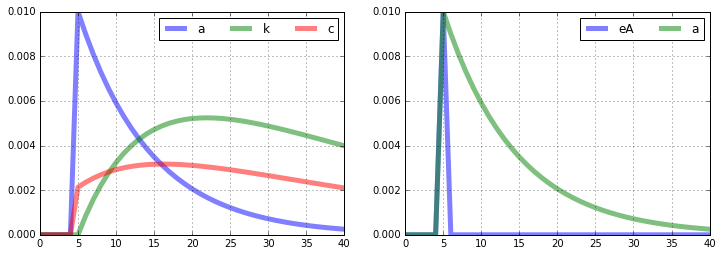

In [18]:
# Input model parameters
parameters = pd.Series()
parameters['alpha']  = .35
parameters['beta']  = 0.99
parameters['delta']   = 0.025
parameters['rhoa'] = .9
parameters['sigma'] = 1.5

# Funtion that evaluates the equilibrium conditions
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Household Euler equation
    euler_eqn = p.beta*fwd.c**-p.sigma*(p.alpha*cur.a*fwd.k**(p.alpha-1)+1-p.delta) - cur.c**-p.sigma
    
    # Goods market clearing
    market_clearing = cur.c + fwd.k - (1-p.delta)*cur.k - cur.a*cur.k**p.alpha
        
    # Exogenous technology
    technology_proc = p.rhoa*np.log(cur.a) - np.log(fwd.a)
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            euler_eqn,
            market_clearing,
            technology_proc
        ])

# Initialize the model
model = ls.model(equations = equilibrium_equations,
                 nstates=2,
                 varNames=['a','k','c'],
                 shockNames=['eA','eK'],
                 parameters = parameters)

# Compute the steady state numerically
guess = [1,1,1]
model.compute_ss(guess)

# Find the log-linear approximation around the non-stochastic steady state and solve
model.approximate_and_solve()

# Compute impulse responses and plot
model.impulse(T=41,t0=5,shock=None)

fig = plt.figure(figsize=(12,4))
ax1 =fig.add_subplot(1,2,1)
model.irs['eA'][['a','k','c']].plot(lw='5',alpha=0.5,grid=True,ax=ax1).legend(loc='upper right',ncol=3)
ax2 =fig.add_subplot(1,2,2)
model.irs['eA'][['eA','a']].plot(lw='5',alpha=0.5,grid=True,ax=ax2).legend(loc='upper right',ncol=2)

### Example 2:  A slightly more elaborate model with explanation 

Consider the equilibrium conditions for a basic RBC model without labor:

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha A_{t+1} K_{t+1}^{\alpha-1} + 1 - \delta)\right]\\
Y_t & = A_t K_t^{\alpha}\\
I_t & = K_{t+1} - (1-\delta)K_t\\
Y_t & = C_t + I_t\\
\log A_t & = \rho_a \log A_{t-1} + \epsilon_t
\end{align}

In the nonstochastic steady state, we have:

\begin{align}
K & = \left(\frac{\alpha A}{1/\beta+\delta-1}\right)^{\frac{1}{1-\alpha}}\\
Y & = AK^{\alpha}\\
I & = \delta K\\
C & = Y - I
\end{align}

Given values for the parameters $\beta$, $\sigma$, $\alpha$, $\delta$, and $A$, steady state values of capital,  output, investment, and consumption are easily computed.

#### Initializing the model in `linearsolve`

To initialize the model, we need to first set the model's parameters. We do this by creating a Pandas Series variable called `parameters`:

In [19]:
# Input model parameters
parameters = pd.Series()
parameters['alpha']  = .35
parameters['beta']  = 0.99
parameters['delta']   = 0.025
parameters['rhoa'] = .9
parameters['sigma'] = 1.5
parameters['A'] = 1

Next, we need to define a function that returns the equilibrium conditions of the model. The function will take as inputs two vectors: one vector of "current" variables and another of "forward-looking" or one-period-ahead variables. The function will return an array that represents the equilibirum conditions of the model. We'll enter each equation with all variables moved to one side of the equals sign. For example, here's how we'll enter the produciton fucntion:

`production_function = technology_current*capital_current**alpha - output_curent`

Here the variable `production_function` stores the production function equation set equal to zero. We can enter the equations in almost any way we want. For example, we could also have entered the production function this way:

`production_function = 1 - output_curent/technology_current/capital_current**alpha`

One more thing to consider: the natural log in the equation describing the evolution of total factor productivity will create problems for the solution routine later on. So rewrite the equation as:

\begin{align}
A_{t+1} & =  A_{t}^{\rho_a}e^{\epsilon_{t+1}}\\
\end{align}

So the complete system of equations that we enter into the program looks like:

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha Y_{t+1} /K_{t+1}+ 1 - \delta)\right]\\
Y_t & = A_t K_t^{\alpha}\\
I_t & = K_{t+1} - (1-\delta)K_t\\
Y_t & = C_t + I_t\\
A_{t+1} & =  A_{t}^{\rho_a}e^{\epsilon_{t+1}}
\end{align}

Now let's define the function that returns the equilibrium conditions:

In [20]:
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current

    # Household Euler equation
    euler_eqn = p.beta*fwd.c**-p.sigma*(p.alpha*fwd.y/fwd.k+1-p.delta) - cur.c**-p.sigma
    
    # Production function
    production_fuction =  cur.a*cur.k**p.alpha - cur.y
    
    # Capital evolution
    capital_evolution = fwd.k - (1-p.delta)*cur.k - cur.i
    
    # Goods market clearing
    market_clearing = cur.c + cur.i - cur.y
        
    # Exogenous technology
    technology_proc = cur.a**p.rhoa- fwd.a
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            euler_eqn,
            production_fuction,
            capital_evolution,
            market_clearing,
            technology_proc
        ])

Notice that inside the function we have to define the variables of the model form the elements of the input vectors `variables_forward` and `variables_current`. It is *essential* that the predetermined or state variables are ordered first.

#### Initializing the model

To initialize the model, we need to specify the number of state variables in the model, the names of the endogenous varaibles in the same order used in the `equilibrium_equations` function, and the names of the exogenous shocks to the model.

In [21]:
# Initialize the model
rbc = ls.model(equations = equilibrium_equations,
               nstates=2,
               varNames=['a','k','c','y','i'],
               shockNames=['eA','eK'],
               parameters=parameters)

The solution routine solves the model as if there were a separate exogenous shock for each state variable and that's why I initialized the model with two exogenous shocks `eA` and `eK` even though the RBC model only has one exogenous shock.

#### Steady state

Next, we need to compute the nonstochastic steady state of the model. The `.compute_ss` method can be used to compute the steady state numerically. The method's default is to use scipy's `fsolve` function, but other scipy root-finding functions can be used: `root`, `broyden1`, and `broyden2`. The optional argument `options` lets the user pass keywords directly to the optimization function. Check out the documentation for Scipy's nonlinear solvers here: http://docs.scipy.org/doc/scipy/reference/optimize.html

In [22]:
# Compute the steady state numerically
guess = [1,1,1,1,1]
rbc.compute_ss(guess)
print(rbc.ss)

a     1.000000
k    34.398226
c     2.589794
y     3.449750
i     0.859956
dtype: float64


Note that the steady state is returned as a Pandas Series. Alternatively, you could compute the steady state directly and then sent the `rbc.ss` attribute:

In [23]:
# Steady state solution
p = parameters
K = (p.alpha*p.A/(1/p.beta+p.delta-1))**(1/(1-p.alpha))
C = p.A*K**p.alpha - p.delta*K
Y = p.A*K**p.alpha
I = Y - C

rbc.set_ss([p.A,K,C,Y,I])
print(rbc.ss)

[  1.          34.39822605   2.58979429   3.44974994   0.85995565]


#### Log-linearization and solution

Now we use the `.log_linear` method to find the log-linear appxoximation to the model's equilibrium conditions. That is, we'll transform the nonlinear model into a linear model in which all variables are expressed as log-deviations from the steady state. Specifically, we'll compute the matrices $A$ and $B$ that satisfy:

\begin{align}
A E_t\left[ x_{t+1} \right] & = B x_t + \left[ \begin{array}{c} \epsilon_{t+1} \\ 0 \end{array} \right],
\end{align}

where the vector $x_{t}$ denotes the log deviation of the endogenous variables from their steady state values.

In [24]:
# Find the log-linear approximation around the non-stochastic steady state
rbc.log_linear_approximation()

print('The matrix A:\n\n',np.around(rbc.a,4),'\n\n')
print('The matrix B:\n\n',np.around(rbc.b,4))

The matrix A:

 [[  0.      -0.0083  -0.3599   0.0083   0.    ]
 [  0.       0.       0.       0.       0.    ]
 [  0.      34.3982   0.       0.       0.    ]
 [  0.       0.       0.       0.       0.    ]
 [ -1.       0.       0.       0.       0.    ]] 


The matrix B:

 [[ -0.      -0.      -0.3599  -0.      -0.    ]
 [ -3.4497  -1.2074  -0.       3.4497  -0.    ]
 [ -0.      33.5383  -0.      -0.       0.86  ]
 [ -0.      -0.      -2.5898   3.4497  -0.86  ]
 [ -0.9     -0.      -0.      -0.      -0.    ]]


Finally, we need to obtain the *solution* to the log-linearized model. The solution is a pair of matrices $F$ and $P$ that specify:

1. The current values of the non-state variables $u_{t}$ as a linear function of the previous values of the state variables $s_t$.
1. The future values of the state variables $s_{t+1}$ as a linear function of the previous values of the state variables $s_t$ and the future realisation of the exogenous shock process $\epsilon_{t+1}$.

\begin{align}
u_t  &  = Fs_t\\
s_{t+1} & = Ps_t + \epsilon_{t+1}.
\end{align}

We use the `.klein` method to find the solution.

In [25]:
# Solve the model
rbc.solve_klein(rbc.a,rbc.b)

# Display the output
print('The matrix F:\n\n',np.around(rbc.f,4),'\n\n')
print('The matrix P:\n\n',np.around(rbc.p,4))

The matrix F:

 [[ 0.2297  0.513 ]
 [ 1.      0.35  ]
 [ 3.3197 -0.1408]] 


The matrix P:

 [[ 0.9     0.    ]
 [ 0.083   0.9715]]


#### Impulse responses

One the model is solved, use the `.impulse` method to compute impulse responses to exogenous shocks to the state. The method creates the `.irs` attribute which is a dictionary with keys equal to the names of the exogenous shocks and the values are Pandas DataFrames with the computed impulse respones. You can supply your own values for the shocks, but the default is 0.01 for each exogenous shock.

In [26]:
# Compute impulse responses and plot
rbc.impulse(T=41,t0=1,shock=None,percent=True)

print('Impulse responses to a 0.01 unit shock to A:\n\n',rbc.irs['eA'].head())

Impulse responses to a 0.01 unit shock to A:

        a         c   eA         i         k         y
0  0.000  0.000000  0.0  0.000000  0.000000  0.000000
1  1.000  0.229718  1.0  3.319739  0.000000  1.000000
2  0.900  0.249318  0.0  2.976083  0.082993  0.929048
3  0.810  0.265744  0.0  2.667127  0.155321  0.864362
4  0.729  0.279348  0.0  2.389390  0.218116  0.805341


Plotting is easy.

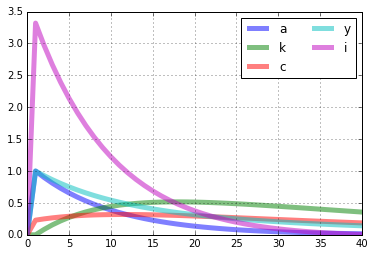

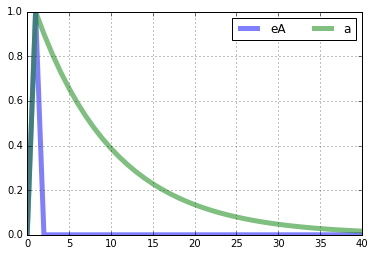

In [27]:
rbc.irs['eA'][['a','k','c','y','i']].plot(lw='5',alpha=0.5,grid=True).legend(loc='upper right',ncol=2)
rbc.irs['eA'][['eA','a']].plot(lw='5',alpha=0.5,grid=True).legend(loc='upper right',ncol=2)

#### Stochastic simulation

Creating a stochastic simulation of the model is straightforward with the `.stoch_sim` method. In the following example, I create a 151 period (including t=0) simulation by first siumlating the model for 251 periods and then dropping the first 100 values. The variance of the shock to $A_t$ is set to 0.001 and the variance of the shock to $K_t$ is set to zero because there is not capital shock in the model. The seed for the numpy random number generator is set to 0.

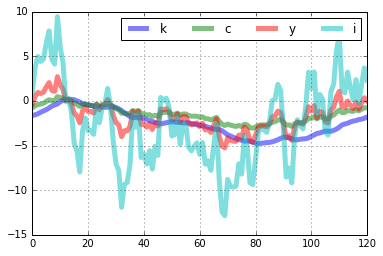

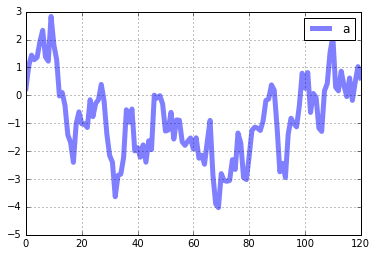

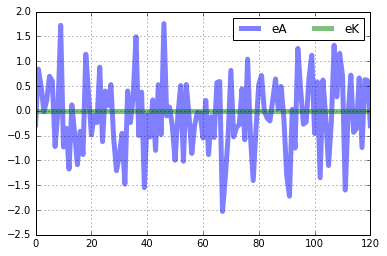

In [28]:
rbc.stoch_sim(T=121,dropFirst=100,covMat=np.array([[0.00763**2,0],[0,0]]),seed=0,percent=True)
rbc.simulated[['k','c','y','i']].plot(lw='5',alpha=0.5,grid=True).legend(loc='upper right',ncol=4)
rbc.simulated[['a']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=4)
rbc.simulated[['eA','eK']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=4)

### Example 3: A New-Keynesian business cycle model

Consider the new-Keynesian model from Walsh (2010), chapter 8 expressed in log-linear terms:

\begin{align}
y_t & = E_ty_{t+1} - \sigma^{-1} (i_t - E_t\pi_{t+1}) + g_t\\
\pi_t & = \beta  E_t\pi_{t+1} + \kappa  y_t + u_t\\
i_t & = \phi_x  y_t + \phi_{\pi}  \pi_t + v_t\\
r_t & = i_t - E_t\pi_{t+1}\\
g_{t+1} & = \rho_g g_{t} + \epsilon_{t+1}^g\\
u_{t+1} & = \rho_u u_{t} + \epsilon_{t+1}^u\\
v_{t+1} & = \rho_v v_{t} + \epsilon_{t+1}^v
\end{align}

where $y_t$ is the output gap (log-deviation of output from the natural rate), $\pi_t$ is the quarterly rate of inflation between $t-1$ and $t$, $i_t$ is the nominal interest rate on funds moving between period $t$ and $t+1$, $r_t$ is the real interest rate, $g_t$ is the exogenous component of demand, $u_t$ is an exogenous component of inflation, and $v_t$ is the exogenous component of monetary policy.

Since the model is already log-linear, there is no need to approximate the equilibrium conditions. We'll still use the `.log_linear` method to find the matrices $A$ and $B$, but we'll have to set the `islinear` option to `True` to avoid generating an error.

In [29]:
# Input model parameters
beta = 0.99
sigma= 1
eta  = 1
omega= 0.8
kappa= (sigma+eta)*(1-omega)*(1-beta*omega)/omega

rhor = 0.9
phipi= 1.5
phiy = 0

rhog = 0.5
rhou = 0.5
rhov = 0.9

Sigma = 0.001*np.eye(3)

# This time we'll input the model parameters a list of values and we'll include a list of name strings. And
# the program will consolidate the information into a Pandas Series. FYI the parameters list is required, 
# but the parameter names is optional. If omitted, the names are set to 'parameter 1', 'parameter 2', etc.

parameters = [beta,sigma,eta,omega,kappa,rhor,phipi,phiy,rhog,rhou,rhov]
parameterNames = ['beta','sigma','eta','omega','kappa','rhor','phipi','phiy','rhog','rhou','rhov']

def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Exogenous demand
    g_proc =  p.rhog*cur.g - fwd.g
    
    # Exogenous inflation
    u_proc =  p.rhou*cur.u - fwd.u
    
    # Exogenous monetary policy
    v_proc =  p.rhov*cur.v - fwd.v
    
    # Euler equation
    euler_eqn = fwd.y -1/p.sigma*(cur.i-fwd.pi) + fwd.g - cur.y
    
    # NK Phillips curve evolution
    phillips_curve = p.beta*fwd.pi + p.kappa*cur.y + fwd.u - cur.pi
    
    # interest rate rule
    interest_rule = p.phiy*cur.y+p.phipi*cur.pi + fwd.v - cur.i
    
    # Fisher equation
    fisher_eqn = cur.i - fwd.pi - cur.r
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            g_proc,
            u_proc,
            v_proc,
            euler_eqn,
            phillips_curve,
            interest_rule,
            fisher_eqn
        ])

# Initialize the nk
nk = ls.model(equilibrium_equations,
              nstates=3,
              varNames=['g','u','v','i','r','y','pi'],
              shockNames=['eG','eU','eV'],
              parameters=parameters,
              parameterNames=parameterNames)

# Set the steady state of the nk
nk.set_ss([0,0,0,0,0,0,0])

# Find the log-linear approximation around the non-stochastic steady state
nk.linear_approximation()

# Solve the nk
nk.solve_klein(nk.a,nk.b)

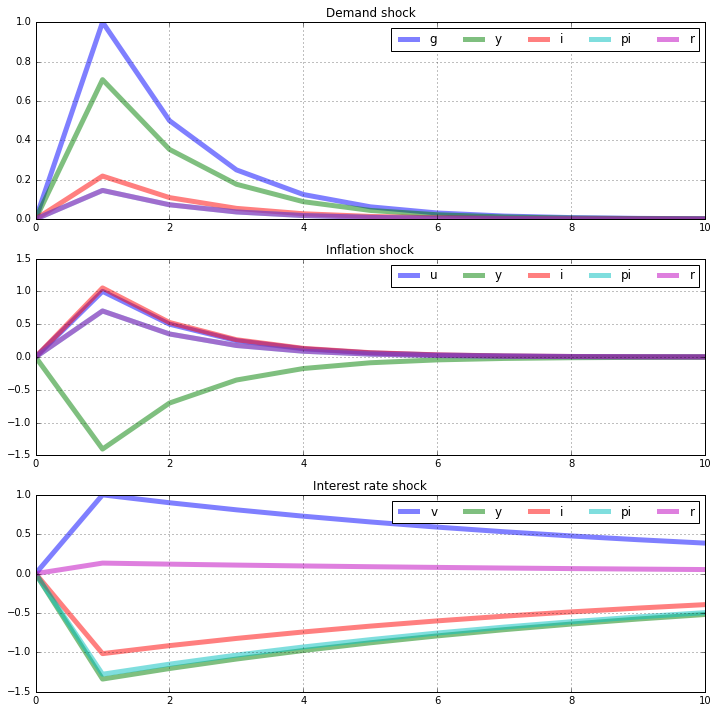

In [30]:
# Compute impulse responses and plot
nk.impulse(T=11,t0=1,shock=None)

# Create the figure and axes
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

# Plot commands
nk.irs['eG'][['g','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Demand shock',ax=ax1).legend(loc='upper right',ncol=5)
nk.irs['eU'][['u','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Inflation shock',ax=ax2).legend(loc='upper right',ncol=5)
nk.irs['eV'][['v','y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Interest rate shock',ax=ax3).legend(loc='upper right',ncol=5)

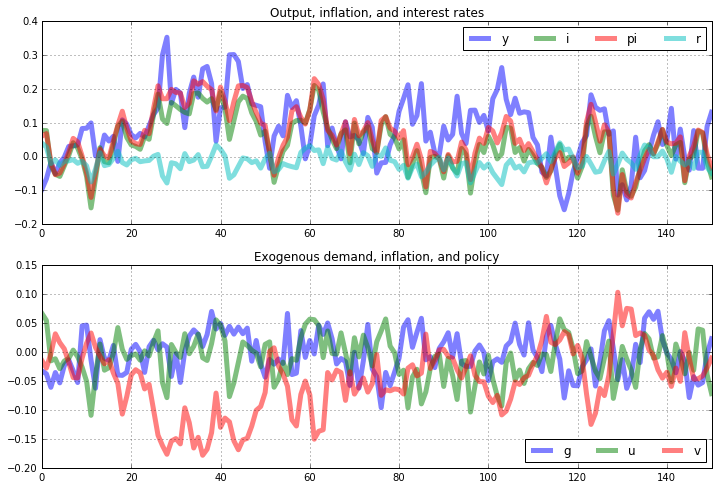

In [31]:
nk.stoch_sim(T=151,dropFirst=100,covMat=Sigma,seed=0)

# Create the figure and axes
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

# Plot commands
nk.simulated[['y','i','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Output, inflation, and interest rates',ax=ax1).legend(ncol=4)
nk.simulated[['g','u','v']].plot(lw='5',alpha=0.5,grid=True,title='Exogenous demand, inflation, and policy',ax=ax2).legend(ncol=4,loc='lower right')

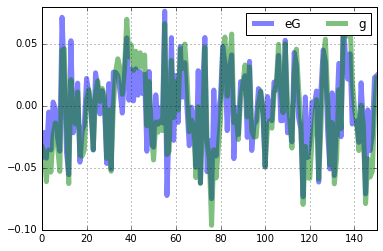

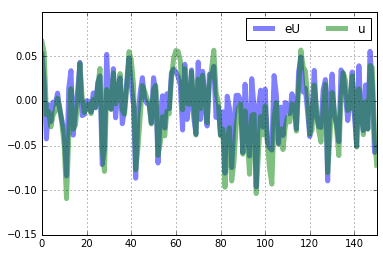

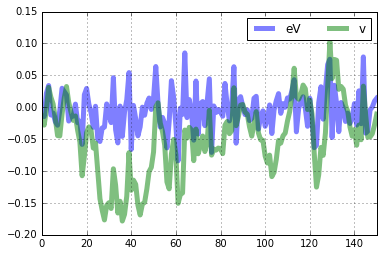

In [32]:
nk.simulated[['eG','g']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)
nk.simulated[['eU','u']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)
nk.simulated[['eV','v']].plot(lw='5',alpha=0.5,grid=True).legend(ncol=2)